In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import nu, fu
from numpy import nan
from pandas import (
    CategoricalDtype, DataFrame, Index, NaT, Series, concat, get_dummies, isna, notnull, read_csv, read_excel, to_datetime, to_numeric
)
from re import split, search, sub, MULTILINE
from scipy.stats import f_oneway, ttest_ind, kruskal, norm
import itertools
import os.path as osp
import re
import statsmodels.api as sm


## Use the CSV Data from the Last Successful Build

In [3]:

# load the CSV data frame from the last successful build
data_frames_dict = nu.load_data_frames(
    verbose=True, metrics_evaluation_open_world_csv_stats_df20240516=''
)
csv_stats_df = data_frames_dict['metrics_evaluation_open_world_csv_stats_df20240516'].copy()
print(csv_stats_df.shape)
print(sorted([cn for cn in csv_stats_df.columns if 'partici' in cn]))

No pickle exists for metrics_evaluation_open_world_csv_stats_df20240516 - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_csv_stats_df20240516.csv.
(158663, 125)
['participant_id']



### Truncate the CSV data to only include our patients at the times they were engaged

In [4]:

# Build a dataset of each CSV file and the action tick where CACI patients first appear
desert_patients_list = [
    'Open World Marine 1 Female Root', 'Open World Marine 2 Male Root', 'Open World Civilian 1 Male Root', 'Open World Civilian 2 Female Root'
]
jungle_patients_list = [
    'Open World Marine 1 Male Root', 'Open World Marine 2 Female Root', 'Open World Marine 3 Male Root', 'Open World Marine 4 Male Root'
]
submarine_patients_list = ['Navy Soldier 1 Male Root', 'Navy Soldier 2 Male Root', 'Navy Soldier 3 Male Root', 'Navy Soldier 4 Female Root']
urban_patients_list = ['Marine 1 Male Root', 'Marine 2 Male Root', 'Marine 3 Male Root', 'Marine 4 Male Root', 'Civilian 1 Female Root']
patients_set = set(desert_patients_list + jungle_patients_list + submarine_patients_list + urban_patients_list)
mask_series = csv_stats_df.patient_id.isin(patients_set)
rows_list = []
for csv_file_name, csv_file_name_df in csv_stats_df[mask_series].groupby('csv_file_name'):
    row_dict = {'csv_file_name': csv_file_name}
    action_tick = csv_file_name_df.action_tick.min()
    row_dict['first_occurence'] = action_tick
    rows_list.append(row_dict)
first_occurence_df = DataFrame(rows_list)
print(first_occurence_df.shape)

(51, 2)


In [5]:

# From each file, filter out the time before the first appearance of the CACI patients
truncated_df = DataFrame([])
for (csv_file_name, first_occurence), _ in first_occurence_df.groupby(['csv_file_name', 'first_occurence']):
    mask_series = (csv_stats_df.csv_file_name == csv_file_name) & (csv_stats_df.action_tick >= first_occurence)
    df = csv_stats_df[mask_series]
    truncated_df = concat([truncated_df, df], axis='index')
print(truncated_df.shape)

(137063, 125)


In [6]:

# Create a list of patients that CACI doesn't care about
mask_series = ~csv_stats_df.patient_id.isin(patients_set) & ~csv_stats_df.patient_id.isnull()
non_patients_list = csv_stats_df[mask_series].patient_id.unique().tolist()
non_patients_list

['patient U Root', 'patient V Root', 'patient W Root', 'patient X Root', 'electrician Root', 'bystander Root', 'Simulation Root', 'Patient V Root', 'Patient U Root', 'Patient W Root', 'Adept Victim Root', 'Adept Shooter Root', 'Patient X Root', 'NPC 2 Root', 'NPC 1 Root', 'NPC 3 Root', 'NPC 4 Root', 'US Soldier 1 Root', 'Local Soldier 1 Root', 'Civilian 1 Root', 'NPC Root', 'Civilian 2 Root']

In [7]:

# Filter out just the patients that CACI doesn't care about
mask_series = ~truncated_df.patient_id.isin(non_patients_list)
truncated_df = truncated_df[mask_series]
print(truncated_df.shape)

(124203, 125)



## Create the Scene Data

In [8]:

# Create the scene data frame precursor
distance_delta_df = fu.get_distance_deltas_data_frame(truncated_df)
print(distance_delta_df.shape)

(67, 17)


In [9]:

# Create the scene stats data frame
rows_list = []
for (session_uuid, scene_id), idx_df in distance_delta_df.groupby(fu.scene_groupby_columns):
    row_dict = list(idx_df.T.to_dict().values())[0]
    
    # mean_patient_count
    patient_count = row_dict.pop('patient_count')
    row_dict.update({'scene_patient_count': patient_count})
    
    # Get the whole scene history
    mask_series = True
    for cn in fu.scene_groupby_columns: mask_series &= (truncated_df[cn] == eval(cn))
    scene_df = truncated_df[mask_series]
    
    if scene_df.shape[0]:
        row_dict['participant_id'] = scene_df.participant_id.iloc[0]
        
        # Get the count of all the patient injuries
        all_patient_injuries_count = 0
        for patient_id, patient_df in scene_df.groupby('patient_id'):
            all_patient_injuries_count += patient_df.injury_id.nunique()
        row_dict['scene_patient_injuries_count'] = all_patient_injuries_count
        
        # percent_injury_correctly_treated
        correctly_treated_count = fu.get_injury_correctly_treated_count(scene_df)
        row_dict['scene_correctly_treated_count'] = correctly_treated_count
        try: percent_injury_correctly_treated = 100 * correctly_treated_count / all_patient_injuries_count
        except ZeroDivisionError: percent_injury_correctly_treated = nan
        row_dict['scene_percent_injury_correctly_treated'] = percent_injury_correctly_treated
        
        # mean_pulse_taken_count
        pulse_taken_count = fu.get_pulse_taken_count(scene_df)
        row_dict['scene_pulse_taken_count'] = pulse_taken_count
        
        # mean_stills_value
        row_dict['scene_stills_value'] = fu.get_stills_value(scene_df)
        
        # mean_teleport_count
        row_dict['scene_teleport_count'] = fu.get_teleport_count(scene_df)
        
        # mean_time_to_hemorrhage_control_per_patient
        row_dict['scene_time_to_hemorrhage_control_per_patient'] = fu.get_time_to_hemorrhage_control_per_patient(scene_df)
        
        # mean_triage_time
        row_dict['scene_triage_time'] = fu.get_triage_time(scene_df)
        
        # mean_percent_accurate_tagging
        # total_action_count
        mask_series = scene_df.action_type.isin(fu.action_types_list)
        row_dict['scene_action_count'] = scene_df[mask_series].shape[0]
        
        # total_assessment_count
        mask_series = scene_df.action_type.isin(['PATIENT_ENGAGED', 'PULSE_TAKEN'])
        row_dict['scene_assessment_count'] = scene_df[mask_series].shape[0]
        
        # total_treatment_count
        mask_series = scene_df.action_type.isin(['INJURY_TREATED'])
        row_dict['scene_treatment_count'] = scene_df[mask_series].shape[0]
        
        # total_tag_application_count
        mask_series = scene_df.action_type.isin(['TAG_APPLIED'])
        row_dict['scene_tag_application_count'] = scene_df[mask_series].shape[0]
        
        # treated_expectant_count
    
    rows_list.append(row_dict)
scene_stats_df = DataFrame(rows_list).drop_duplicates()
print(scene_stats_df.shape)

(67, 30)


In [10]:

# Add the encounter layout column
new_column_name = 'encounter_layout'
encounter_layouts_list = ['Desert', 'Jungle', 'Submarine', 'Urban']
for (session_uuid, scene_id), scene_df in csv_stats_df.groupby(fu.scene_groupby_columns):
    for env_str in encounter_layouts_list:
        patients_list = eval(f'{env_str.lower()}_patients_list')
        if all(map(lambda patient_id: patient_id in scene_df.patient_id.unique().tolist(), patients_list)):
            mask_series = (scene_stats_df.session_uuid == session_uuid) & (scene_stats_df.scene_id == scene_id)
            scene_stats_df.loc[mask_series, new_column_name] = env_str
print(scene_stats_df.groupby(new_column_name, dropna=False).size().to_frame().rename(columns={0: 'record_count'}))

                  record_count
encounter_layout              
Desert                      15
Jungle                      13
Submarine                   13
Urban                       13
NaN                         13



### Add the mean % accurate tagging column

In [11]:

# Create the tag-to-SALT data frame
tag_to_salt_df = fu.get_is_tag_correct_data_frame(truncated_df, groupby_column='participant_id')

In [12]:

# Get the percentage tag correct counts for each scene for each group
correct_count_by_tag_df = fu.get_percentage_tag_correct_data_frame(tag_to_salt_df, groupby_column='participant_id')

In [13]:

# Group the scene stats by participant ID to get the tagging accuracy measure
for participant_id, idx_df in scene_stats_df.groupby('participant_id'):
    
    # mean_percent_accurate_tagging
    mask_series = (correct_count_by_tag_df.participant_id == participant_id)
    scene_stats_df.loc[idx_df.index, 'mean_percent_accurate_tagging'] = correct_count_by_tag_df[mask_series].percentage_tag_correct.mean()


### Add the treated-expectant count column

In [14]:

# Loop through each patient to build the max salt and treated-expectant measures
rows_list = []
for (session_uuid, scene_id, patient_id), patient_df in truncated_df.groupby(fu.patient_groupby_columns):
    row_dict = {cn: eval(cn) for cn in fu.patient_groupby_columns}
    row_dict['max_salt'] = fu.get_max_salt(patient_df, session_uuid=session_uuid, scene_id=scene_id, random_patient_id=patient_id)[1]
    if (row_dict['max_salt'] == 'EXPECTANT'):
        mask_series = ~patient_df.injury_treated_required_procedure.isnull() | ~patient_df.tool_applied_type.isnull()
        row_dict['treated_expectant'] = {True: 'yes', False: 'no'}[mask_series.any()]
    else: row_dict['treated_expectant'] = nan
    rows_list.append(row_dict)
treated_expectant_df = DataFrame(rows_list)

In [15]:

# Loop through each scene to build the treated-expectant counts
for (session_uuid, scene_id), scene_df in treated_expectant_df.groupby(fu.scene_groupby_columns):
    mask_series = (scene_df.treated_expectant == 'yes')
    
    # treated_expectant_count
    treated_expectant_count = mask_series.sum()
    mask_series = (scene_stats_df.session_uuid == session_uuid) & (scene_stats_df.scene_id == scene_id)
    scene_stats_df.loc[mask_series, 'treated_expectant_count'] = treated_expectant_count

In [16]:

# Add the survey columns
survey_columns = ['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text']
if any(map(lambda x: x not in scene_stats_df.columns, survey_columns)):
    file_path = osp.join(nu.data_folder, 'xlsx', 'participant_data_0420.xlsx')
    participant_data_df = read_excel(file_path).rename(columns={'ParticipantID': 'participant_id'})
    
    print("\nColumns to merge the participant data with the scene stats on:")
    on_columns = sorted(set(scene_stats_df.columns).intersection(set(participant_data_df.columns)))
    assert on_columns, "You have nothing to merge the participant dataset with the scene stats on"
    print(on_columns)

    print("\nThe participant data columns we want to have in the merge:")
    survey_set = set(on_columns + survey_columns)
    all_set = set(participant_data_df.columns)
    assert survey_set.issubset(all_set), f"You're missing {survey_set.difference(all_set)} from participant_data_0420.xlsx"
    columns_list = sorted(survey_set)
    print(columns_list)
    
    # mean_AD_KDMA_Sim
    # mean_AD_KDMA_Text
    # mean_PropTrust
    # mean_ST_KDMA_Sim
    # mean_ST_KDMA_Text
    scene_stats_df = scene_stats_df.merge(participant_data_df[columns_list], how='left', on=on_columns)


Columns to merge the participant data with the scene stats on:
['participant_id']

The participant data columns we want to have in the merge:
['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'participant_id']



### Truncate the scene data to only include our patients at the times they were engaged

In [17]:

# Filter out the unnamed layouts
mask_series = scene_stats_df.encounter_layout.isin(encounter_layouts_list)
pre_count = scene_stats_df.shape[0]
scene_stats_df = scene_stats_df[mask_series]
print(f"\nFiltered out {pre_count - scene_stats_df.shape[0]} unnamed encounter layouts")


Filtered out 13 unnamed encounter layouts


In [18]:

# Check for zero teleports
mask_series = (scene_stats_df.scene_teleport_count < 1)
print(f"\nThere are {scene_stats_df[mask_series].shape[0]} out of {scene_stats_df.shape[0]} scenes with no teleports")


There are 0 out of 54 scenes with no teleports


In [19]:

# Save the scene stats dataset
nu.save_data_frames(truncated_scene_stats_df=scene_stats_df, verbose=True)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/truncated_scene_stats_df.csv



## Create the ANOVA Dataframe

In [20]:

# Get the columns to merge the scene stats dataset with the CSV stats on
print("\nColumns to merge the scene stats dataset with the CSV stats on:")
on_columns = sorted(set(csv_stats_df.columns).intersection(set(scene_stats_df.columns)))
print(on_columns)


Columns to merge the scene stats dataset with the CSV stats on:
['participant_id', 'scene_id', 'session_uuid']


In [21]:

# Get the scene stats dataset columns we want to have in the merge
print('\nThe scene stats dataset columns we want to have in the merge:')
mean_analysis_columns = sorted([
    'scene_percent_injury_correctly_treated', 'scene_pulse_taken_count', 'scene_stills_value', 'scene_teleport_count',
    'scene_time_to_hemorrhage_control_per_patient', 'scene_triage_time', 'scene_patient_count', 'mean_percent_accurate_tagging'
] + survey_columns)
sum_analysis_columns = sorted([
    'scene_action_count', 'scene_assessment_count', 'scene_treatment_count', 'scene_tag_application_count', 'treated_expectant_count'
])
analysis_set = set(mean_analysis_columns + sum_analysis_columns)
all_set = set(scene_stats_df.columns)
assert analysis_set.issubset(all_set), f"You're missing {analysis_set.difference(all_set)} from your analysis_columns"
print(analysis_set)


The scene stats dataset columns we want to have in the merge:
{'ST_KDMA_Sim', 'ST_KDMA_Text', 'scene_pulse_taken_count', 'scene_percent_injury_correctly_treated', 'scene_teleport_count', 'AD_KDMA_Text', 'scene_time_to_hemorrhage_control_per_patient', 'scene_triage_time', 'scene_treatment_count', 'AD_KDMA_Sim', 'scene_stills_value', 'scene_action_count', 'scene_tag_application_count', 'scene_patient_count', 'mean_percent_accurate_tagging', 'scene_assessment_count', 'PropTrust', 'treated_expectant_count'}


In [22]:

# Merge the scene stats with the CSV stats
print("\nMerge the scene stats with the CSV stats")
columns_list = on_columns + mean_analysis_columns + sum_analysis_columns
assert set(columns_list).issubset(set(scene_stats_df.columns)), "You've lost access to the analysis columns"
merge_df = csv_stats_df.merge(scene_stats_df[columns_list], on=on_columns, how='left').drop_duplicates()


Merge the scene stats with the CSV stats


In [23]:

# Get the merge dataset columns we want to have in the groupby
print('\nThe merge dataset columns we want to have in the groupby:')
columns_list = sorted(set(
    on_columns + mean_analysis_columns + sum_analysis_columns
).intersection(set(merge_df.columns)))
print(columns_list)


The merge dataset columns we want to have in the groupby:
['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'mean_percent_accurate_tagging', 'participant_id', 'scene_action_count', 'scene_assessment_count', 'scene_id', 'scene_patient_count', 'scene_percent_injury_correctly_treated', 'scene_pulse_taken_count', 'scene_stills_value', 'scene_tag_application_count', 'scene_teleport_count', 'scene_time_to_hemorrhage_control_per_patient', 'scene_treatment_count', 'scene_triage_time', 'session_uuid', 'treated_expectant_count']


In [24]:

# Get the numeric columns we want to take the mean of
print("\nThe numeric columns we want to take the mean of:")
df = merge_df[on_columns + mean_analysis_columns]
assert set(df.columns).issubset(set(merge_df.columns)), "You've lost access to the mean analysis columns"
mean_numeric_columns = sorted(set(nu.get_numeric_columns(df)).difference(set(
    on_columns
)))
print(mean_numeric_columns)


The numeric columns we want to take the mean of:
['AD_KDMA_Sim', 'AD_KDMA_Text', 'PropTrust', 'ST_KDMA_Sim', 'ST_KDMA_Text', 'mean_percent_accurate_tagging', 'scene_patient_count', 'scene_percent_injury_correctly_treated', 'scene_pulse_taken_count', 'scene_stills_value', 'scene_teleport_count', 'scene_time_to_hemorrhage_control_per_patient', 'scene_triage_time']


In [25]:

# Get the numeric columns we want to take the sum of
print("\nThe numeric columns we want to take the sum of:")
df = merge_df[on_columns + sum_analysis_columns]
assert set(df.columns).issubset(set(merge_df.columns)), "You've lost access to the sum analysis columns"
sum_numeric_columns = sorted(set(nu.get_numeric_columns(df)).difference(set(
    on_columns
)))
print(sum_numeric_columns)


The numeric columns we want to take the sum of:
['scene_action_count', 'scene_assessment_count', 'scene_tag_application_count', 'scene_treatment_count', 'treated_expectant_count']


In [26]:

# Get the other columns we do not want to take the mean or sum of
print("\nThe other columns we do not want to take the mean or sum of:")
other_columns = sorted(set(on_columns + mean_analysis_columns + sum_analysis_columns).difference(set(
    mean_numeric_columns + sum_numeric_columns
)))
print(other_columns)


The other columns we do not want to take the mean or sum of:
['participant_id', 'scene_id', 'session_uuid']


In [27]:

# Get the means and sums datasets and the columns to merge the summed half of the merge with the meaned half of the merge on
means_df = merge_df[mean_numeric_columns+on_columns].groupby(on_columns).mean().reset_index(drop=False).rename(
    columns={cn: 'mean_'+cn.replace('mean_', '').replace('scene_', '') for cn in mean_numeric_columns}
).dropna(axis='columns', how='all')
sums_df = merge_df[sum_numeric_columns+on_columns].groupby(on_columns).sum().reset_index(drop=False).rename(
    columns={cn: 'sum_'+cn.replace('sum_', '').replace('scene_', '') for cn in sum_numeric_columns}
).dropna(axis='columns', how='all')
print("\nColumns to merge the summed half of the merge with the meaned half of the merge on:")
on_columns = sorted(set(means_df.columns).intersection(set(sums_df.columns)))
print(on_columns)
left_df = means_df.merge(sums_df, on=on_columns, how='outer').drop_duplicates()


Columns to merge the summed half of the merge with the meaned half of the merge on:
['participant_id', 'scene_id', 'session_uuid']


In [28]:

# Get the columns to merge the unaggregated half of the merge with the aggregated half of the merge on
right_df = merge_df[other_columns].drop_duplicates().dropna(axis='columns', how='all')
print("\nColumns to merge the unaggregated half of the merge with the aggregated half of the merge on:")
on_columns = sorted(set(left_df.columns).intersection(set(right_df.columns)))
print(on_columns)


Columns to merge the unaggregated half of the merge with the aggregated half of the merge on:
['participant_id', 'scene_id', 'session_uuid']


In [29]:

# Merge the unaggregated half of the merge with the aggregated half
print(
    "\nAggregate the data from the merged datasets and group by participant, session,"
    " and scene to get the means and sums of the numeric columns"
)
anova_df = left_df.merge(right_df, on=on_columns, how='outer').drop_duplicates()
assert set(
    ['mean_'+cn for cn in survey_columns]
).issubset(set(anova_df.columns)), "You've lost acces to the survey columns (PropTrust, et al)"
assert len(anova_df.groupby(
    ['participant_id', 'scene_id', 'session_uuid']
).groups.keys()) == anova_df.shape[0], "You have duplicate rows in anova_df"


Aggregate the data from the merged datasets and group by participant, session, and scene to get the means and sums of the numeric columns


In [30]:

# Add the sim environment back in
print("\nAdd the sim environment back in")
new_column = 'encounter_layout'
on_columns = sorted(set(anova_df.columns).intersection(set(scene_stats_df.columns)))
columns_list = on_columns + [new_column]
assert set(columns_list).issubset(set(scene_stats_df.columns)), f"You've lost acces to the {new_column} column"
anova_df = anova_df.merge(
    scene_stats_df[columns_list], on=on_columns, how='left'
)
print(anova_df.groupby(new_column).size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))


Add the sim environment back in
                  record_count
encounter_layout              
Desert                      15
Jungle                      13
Submarine                   13
Urban                       13


In [31]:

# Check for low patient counts
mask_series = (anova_df.mean_patient_count < 4)
print(f"\nThere are {anova_df[mask_series].shape[0]} out of {anova_df.shape[0]} participations with low patient counts")


There are 0 out of 68 participations with low patient counts


In [32]:

# Store the results
columns_list = anova_df.columns.tolist()
nu.save_data_frames(truncated_anova_df=anova_df[columns_list], verbose=True)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/truncated_anova_df.csv


In [33]:

# Formally describe the analytic columns
columns_list = ['mean_'+cn for cn in survey_columns] + [
    'mean_percent_accurate_tagging', 'mean_patient_count', 'mean_percent_injury_correctly_treated', 'mean_pulse_taken_count',
    'mean_stills_value', 'mean_teleport_count', 'mean_time_to_hemorrhage_control_per_patient', 'mean_triage_time',
    'sum_action_count', 'sum_assessment_count', 'sum_tag_application_count', 'sum_treatment_count', 'sum_treated_expectant_count'
]
anova_df[columns_list].describe().T

,count,mean,std,min,25%,50%,75%,max
mean_AD_KDMA_Sim,54.0,4.229938e-01,1.081691e-01,0.175000,0.341667,4.416667e-01,4.750000e-01,8.000000e-01
mean_AD_KDMA_Text,54.0,4.083333e-01,9.269718e-02,0.141667,0.366667,4.166667e-01,4.666667e-01,6.250000e-01
mean_PropTrust,51.0,3.627451e+00,9.058993e-01,0.000000,3.666667,4.000000e+00,4.000000e+00,4.333333e+00
mean_ST_KDMA_Sim,54.0,5.524821e-01,6.101352e-02,0.361538,0.530528,5.538462e-01,5.955128e-01,6.433566e-01
mean_ST_KDMA_Text,54.0,3.778463e-01,8.540882e-02,0.222553,0.312732,3.809398e-01,4.315112e-01,5.691236e-01
mean_percent_accurate_tagging,54.0,3.111111e+01,2.030003e+01,0.000000,12.625000,2.875000e+01,4.250000e+01,7.500000e+01
mean_patient_count,54.0,4.240741e+00,4.315477e-01,4.000000,4.000000,4.000000e+00,4.000000e+00,5.000000e+00
mean_percent_injury_correctly_treated,52.0,3.726908e+01,2.654799e+01,0.000000,13.621795,4.006410e+01,5.785714e+01,8.500000e+01
mean_pulse_taken_count,54.0,8.111111e+00,7.642154e+00,0.000000,2.000000,6.000000e+00,1.175000e+01,2.600000e+01
mean_stills_value,54.0,6.851852e-01,4.688031e-01,0.000000,0.000000,1.000000e+00,1.000000e+00,1.000000e+00


In [34]:

# Get statistics using OSU format
columns_list = ['mean_'+cn for cn in survey_columns] + [
    'mean_percent_accurate_tagging', 'mean_patient_count', 'mean_percent_injury_correctly_treated', 'mean_pulse_taken_count',
    'mean_stills_value', 'mean_teleport_count', 'mean_time_to_hemorrhage_control_per_patient', 'mean_triage_time',
    'sum_action_count', 'sum_assessment_count', 'sum_tag_application_count', 'sum_treatment_count', 'sum_treated_expectant_count'
]
description_df = nu.get_statistics(anova_df, columns_list).T

# Calculate range and IQR
description_df['range'] = description_df['max'] - description_df['min']
description_df['IQR'] = description_df['75%'] - description_df['25%']

# Define the index list
index_list = ['min', 'median', 'max', 'IQR', 'range', 'mean', 'SD']

# Set formatting to prevent scientific notation (assuming numeric columns)
description_df = description_df[index_list].applymap('{:.4f}'.format)  # Format as floats with 4 decimals

# Display the DataFrame subset
nu.save_data_frames(description_df=description_df, verbose=True)
display(description_df)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/description_df.csv


,min,median,max,IQR,range,mean,SD
mean_AD_KDMA_Sim,0.1750,0.4417,0.8000,0.1333,0.6250,0.4230,0.1082
mean_AD_KDMA_Text,0.1417,0.4167,0.6250,0.1000,0.4833,0.4083,0.0927
mean_PropTrust,0.0000,4.0000,4.3333,0.3333,4.3333,3.6275,0.9059
mean_ST_KDMA_Sim,0.3615,0.5538,0.6434,0.0650,0.2818,0.5525,0.0610
mean_ST_KDMA_Text,0.2226,0.3809,0.5691,0.1188,0.3466,0.3778,0.0854
mean_percent_accurate_tagging,0.0000,28.7500,75.0000,29.8750,75.0000,31.1111,20.3000
mean_patient_count,4.0000,4.0000,5.0000,0.0000,1.0000,4.2407,0.4315
mean_percent_injury_correctly_treated,0.0000,40.0641,85.0000,44.2353,85.0000,37.2691,26.5480
mean_pulse_taken_count,0.0000,6.0000,26.0000,9.7500,26.0000,8.1111,7.6422
mean_stills_value,0.0000,1.0000,1.0000,1.0000,1.0000,0.6852,0.4688



# Plot the Correlations

In [35]:

# Define a means to plot a correlation graph
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt

def plot_correlation_graph(correlations, title_str='Correlation Matrix of ??', ax=None):
    
    # Plotting the correlation matrix using matplotlib
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    cmap = plt.get_cmap('coolwarm')
    norm = colors.Normalize(vmin=-1, vmax=1)

    # Create the heatmap
    cax = ax.matshow(correlations, cmap=cmap, norm=norm)

    # Add a color bar
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(correlations.columns)))
    ax.set_yticks(np.arange(len(correlations.columns)))
    ax.set_xticklabels(correlations.columns)
    ax.set_yticklabels(correlations.columns)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')

    # Add text annotations.
    for (i, j), val in np.ndenumerate(correlations):
        ax.text(j, i, f'{val:.3f}', ha='center', va='center', color='black', fontsize=84/correlations.shape[0])
    plt.title(title_str)
    plt.show()

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/correlations_df.csv


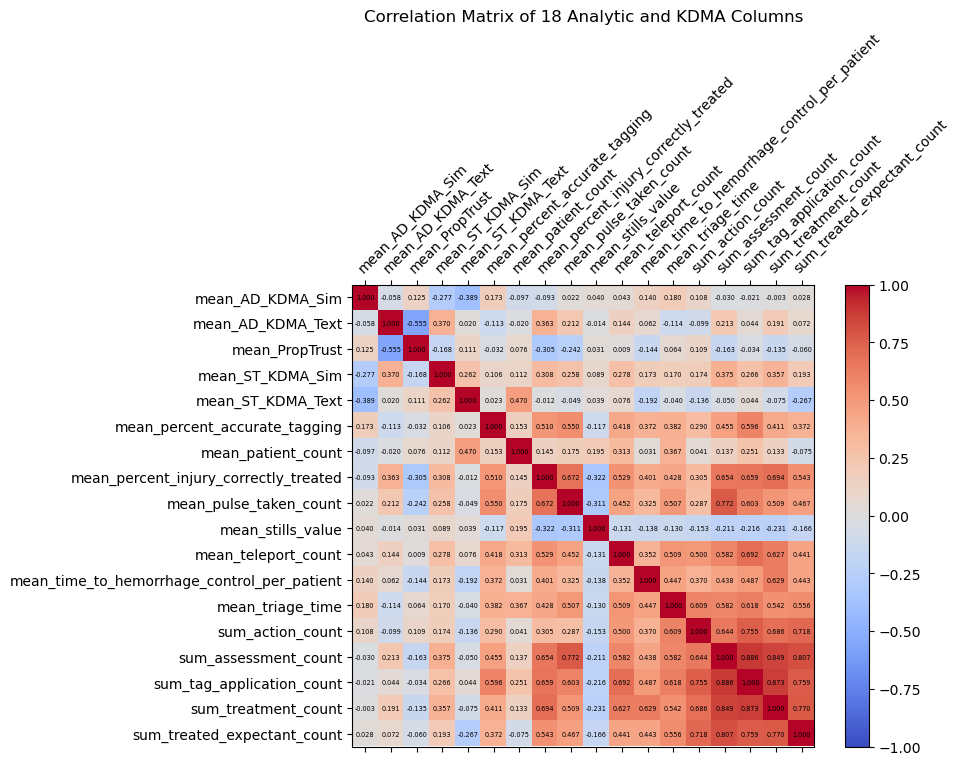

In [36]:

# Plot the correlations of all the numeric columns in the ANOVA dataset
columns_list = ['mean_'+cn for cn in survey_columns] + [
    'mean_percent_accurate_tagging', 'mean_patient_count', 'mean_percent_injury_correctly_treated', 'mean_pulse_taken_count',
    'mean_stills_value', 'mean_teleport_count', 'mean_time_to_hemorrhage_control_per_patient', 'mean_triage_time',
    'sum_action_count', 'sum_assessment_count', 'sum_tag_application_count', 'sum_treatment_count', 'sum_treated_expectant_count'
]
# columns_list = ['mean_'+cn for cn in survey_columns]
df = anova_df[columns_list]
correlations_df = df.corr().round(3)
nu.save_data_frames(correlations_df=correlations_df, verbose=True)
plot_correlation_graph(correlations_df, title_str=f"Correlation Matrix of 18 Analytic and KDMA Columns")